In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from wrangle_zillow import wrangle_zillow, summarize


# Exercises

Sourcing the Zillow database as the data source, create a jupyter notebook named explore_zillow and do the following:

Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Answer those questions through a mix of statistical tests and visualizations.

## Wrangle

In [2]:
# import importlib
# importlib.reload(wrangle_zillow) 
# 

In [3]:
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow()

(18398, 20) (7886, 20) (6572, 20)
-----
DataFrame info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32856 entries, 2288172 to 1187175
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   32856 non-null  float64
 1   bedroomcnt                    32856 non-null  float64
 2   calculatedbathnbr             32856 non-null  float64
 3   calculatedfinishedsquarefeet  32856 non-null  float64
 4   finishedsquarefeet12          32856 non-null  float64
 5   fips                          32856 non-null  object 
 6   latitude                      32856 non-null  float64
 7   longitude                     32856 non-null  float64
 8   lotsizesquarefeet             32856 non-null  float64
 9   propertycountylandusecode     32856 non-null  object 
 10  propertyzoningdesc            32856 non-null  object 
 11  roomcnt                       32856 non-null  float64


## Explore - Univariate

In [4]:
#after eliminated nulls only able to view homes within fips 6037
df.fips.value_counts()

6037.0    32856
Name: fips, dtype: int64

In [36]:
num_cols = train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

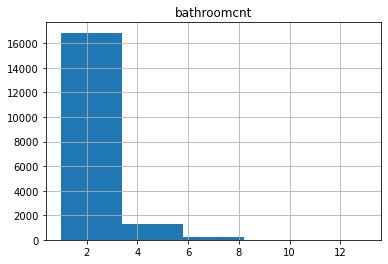

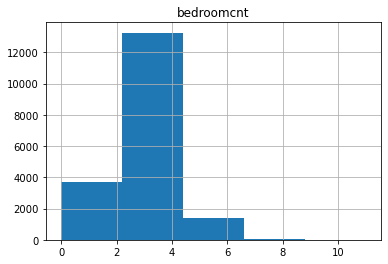

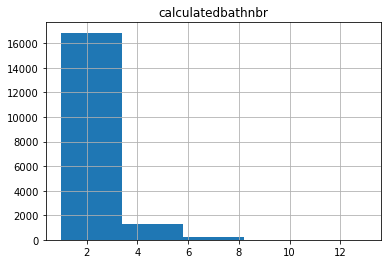

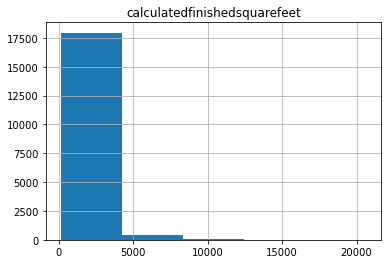

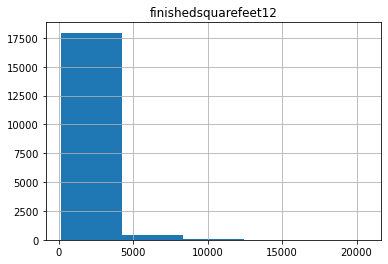

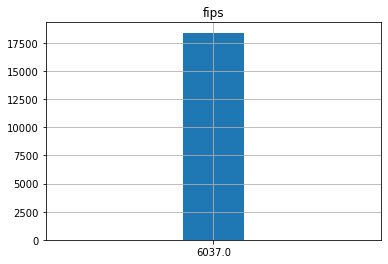

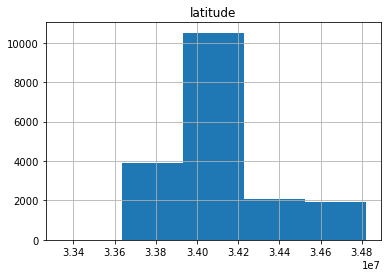

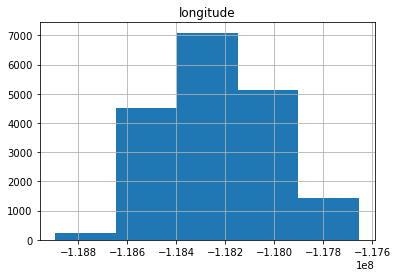

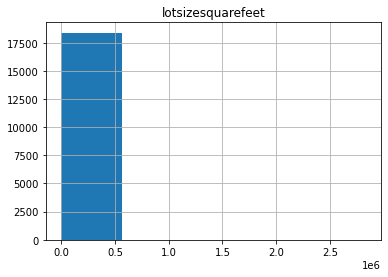

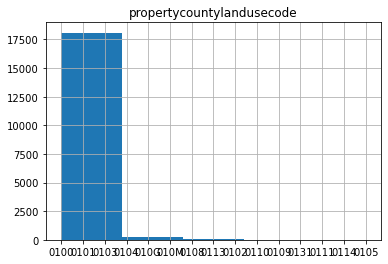

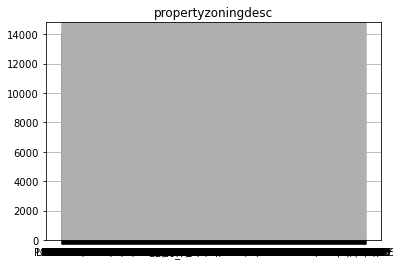

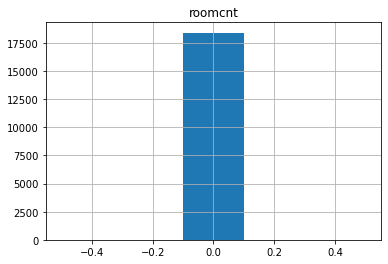

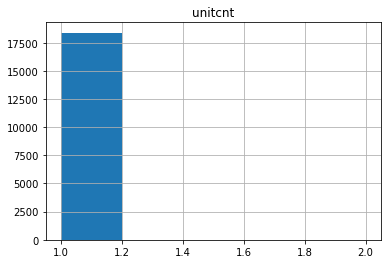

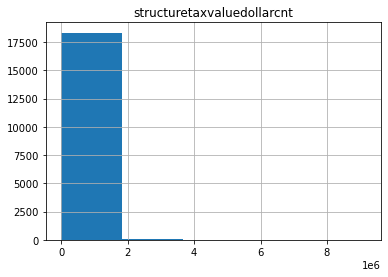

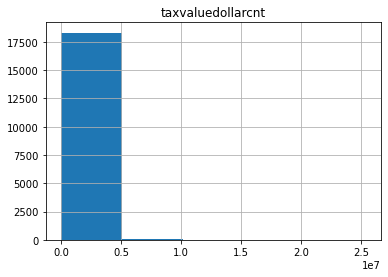

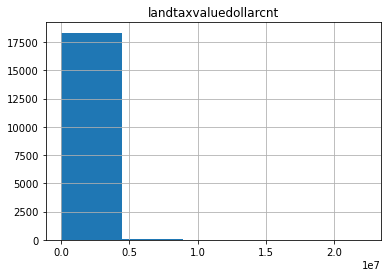

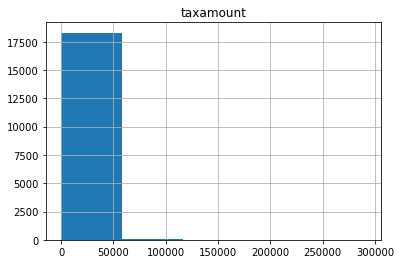

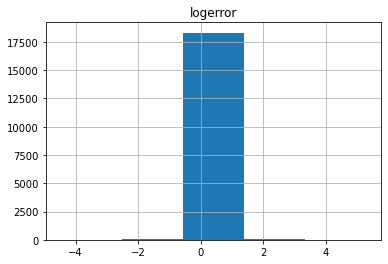

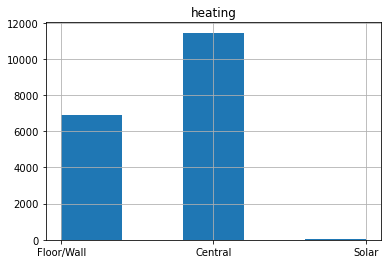

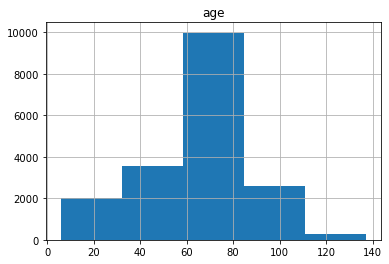

In [6]:
for col in train.columns:
    train[col].hist(bins=5)
    plt.title(col)
    plt.show()


In [7]:
def remove_outliers(df, col_list, k=1.5):
    """ 
    Purpose
        Remove outliers from a list of columns in a dataframe and return that dataframe
    
    Parameters
        df: a dataframe containing zillow real estate data
        k: factor to multiple IQR
        col_list: a list of dataframe columns to work on 

    Returns
        df: a dataframe with the desired adjustments
    """

    # total number of observations
    num_obs = df.shape[0]
        
    # Create a column that will label our rows as containing an outlier. sets default value
    df['outlier'] = False

    # loop through the columns provided to find appropriate values and labels
    for col in col_list:

        # find quartiles
        q1, q3 = df[col].quantile([.25, .75])  
        
       # get interquartile range
        iqr = q3 - q1

       # find upper/lower bounds 
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # update the outlier label as needed. 
        df['outlier'] = np.where(((df[col] < lower_bound) | (df[col] > upper_bound)) & (df.outlier == False), True, df.outlier)
    
    # set dataframe to dataframe w/o the outliers
    df = df[df.outlier == False]

    # drop the outlier column from the dataFrame. no longer needed
    df.drop(columns=['outlier'], inplace=True)

    # print out number of removed observations
    print(f"Number of observations removed: {num_obs - df.shape[0]}")
        
    return df

In [8]:
train = remove_outliers(train, num_cols)

Number of observations removed: 6971


/var/folders/x7/9w9mh0fd73zg4jr8l_9v9h840000gn/T/ipykernel_22865/2360479568.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['outlier'], inplace=True)


### Takeaways
* skewed (watching for outliers) 
    - bathroomcant, calculatedbathnbr, calculatedfinishedsquarefeet,fnishiedsquarefeet12, lotsizesquarefeet, taxvaluedollarcnt,
    - landtaxvaluedollarcnt, taxamount
* normal 
    - bedroomcnt
* need better visual/further examination  
    -  propertyzoningdesc, unitcnt,
* can possibly drop/change
    - drop (moved to wrangle): unitcnt, roomcnt, regionidcounty, **finishedsquarefeet12**, **fullbathcnt**, assessmentyear
    - change: regionidzip, regionidcity, propertylandusecode, fips, yearbuilt, rawcensustractandblock


Explore - Bivariate 
* Everything vs. logerror

In [9]:
train['abs_error'] = abs(train.logerror)

/var/folders/x7/9w9mh0fd73zg4jr8l_9v9h840000gn/T/ipykernel_22865/1648977266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['abs_error'] = abs(train.logerror)


In [10]:
train.logerror

id
2824623    0.040715
2777122    0.041872
1170886   -0.113134
1433983    0.013209
1351603    0.065250
             ...   
468741     0.039510
1665879   -0.059168
1777558    0.018634
633691    -0.022243
1783153    0.024593
Name: logerror, Length: 11427, dtype: float64

In [11]:
train['pos/neg error'] = train['logerror'].apply(lambda x: 'positive' if x >= 0 else 'negative')

/var/folders/x7/9w9mh0fd73zg4jr8l_9v9h840000gn/T/ipykernel_22865/3089752545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pos/neg error'] = train['logerror'].apply(lambda x: 'positive' if x >= 0 else 'negative')


<Figure size 1008x432 with 0 Axes>

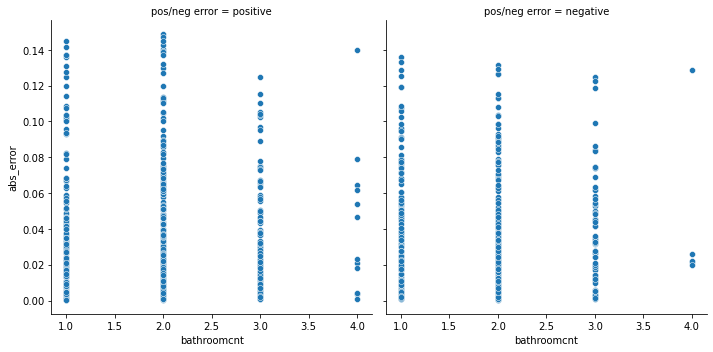

<Figure size 1008x432 with 0 Axes>

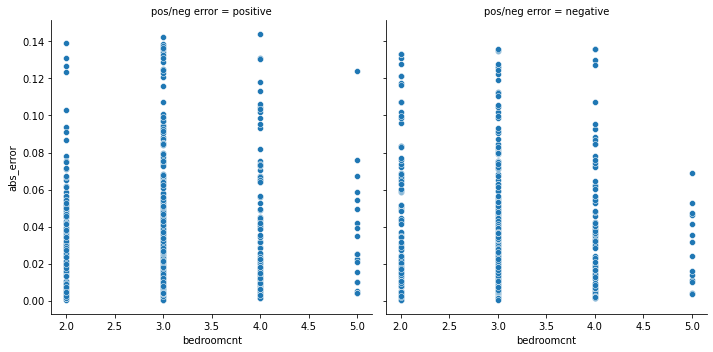

<Figure size 1008x432 with 0 Axes>

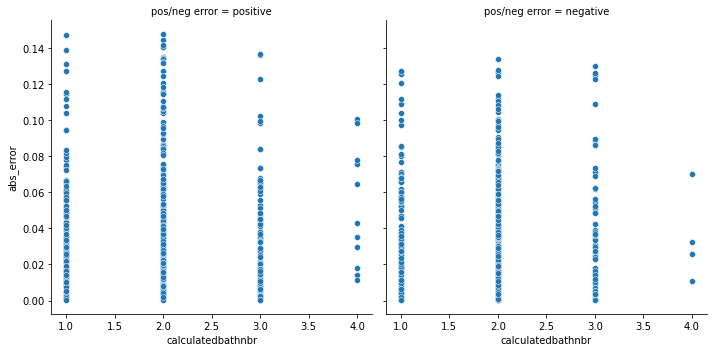

<Figure size 1008x432 with 0 Axes>

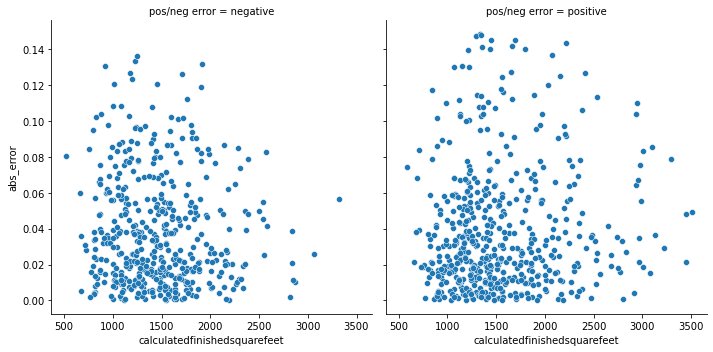

<Figure size 1008x432 with 0 Axes>

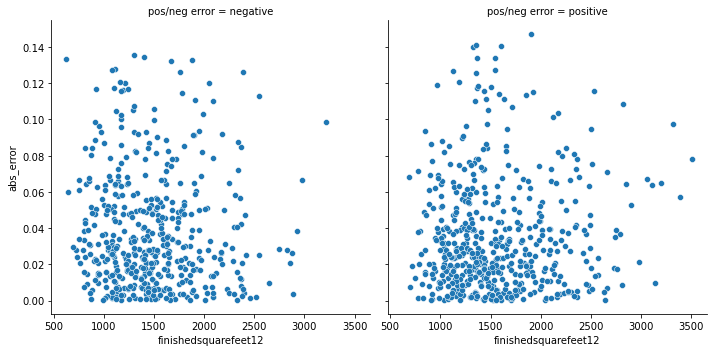

<Figure size 1008x432 with 0 Axes>

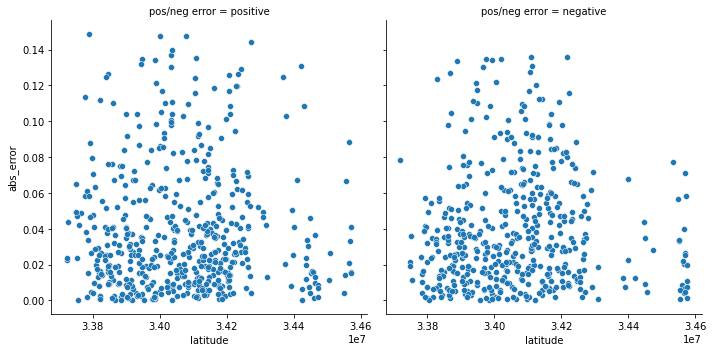

<Figure size 1008x432 with 0 Axes>

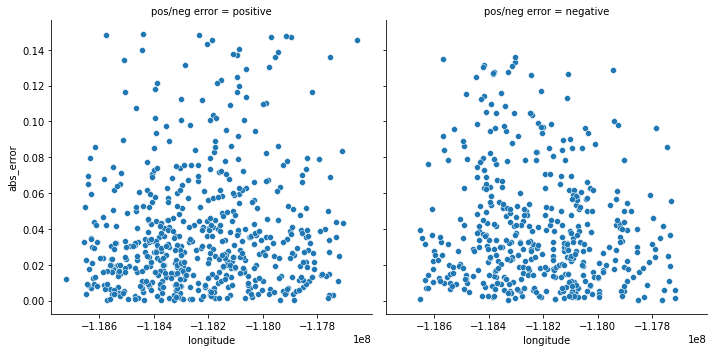

<Figure size 1008x432 with 0 Axes>

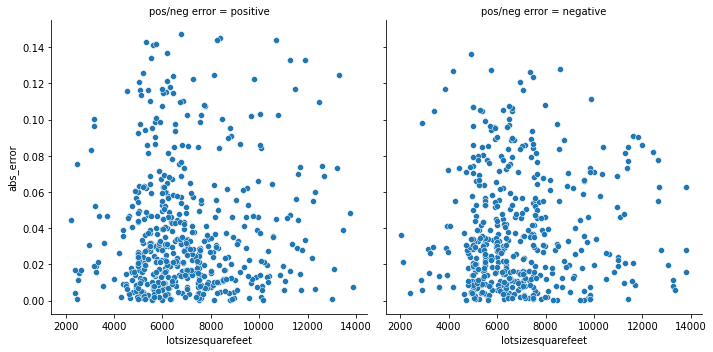

<Figure size 1008x432 with 0 Axes>

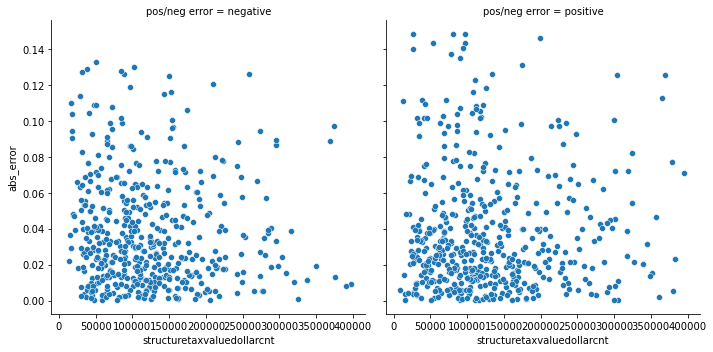

<Figure size 1008x432 with 0 Axes>

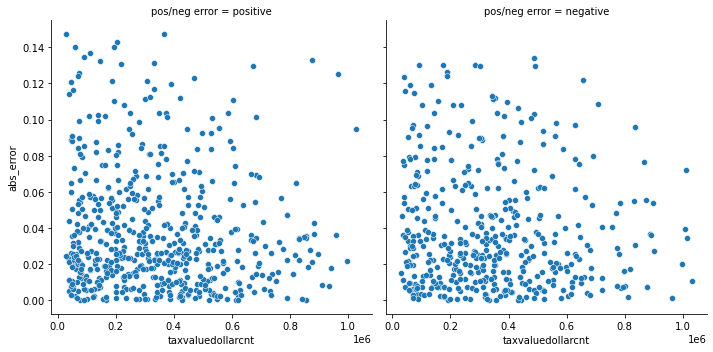

<Figure size 1008x432 with 0 Axes>

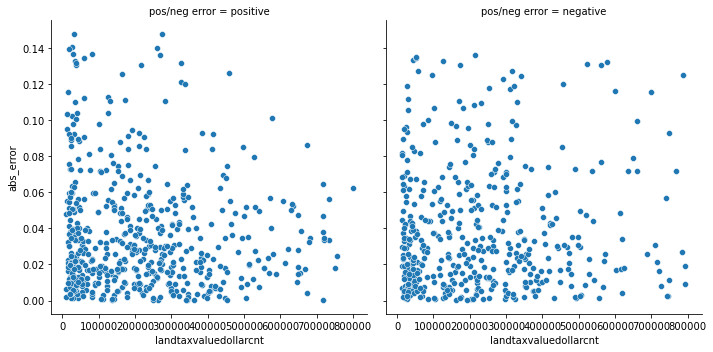

<Figure size 1008x432 with 0 Axes>

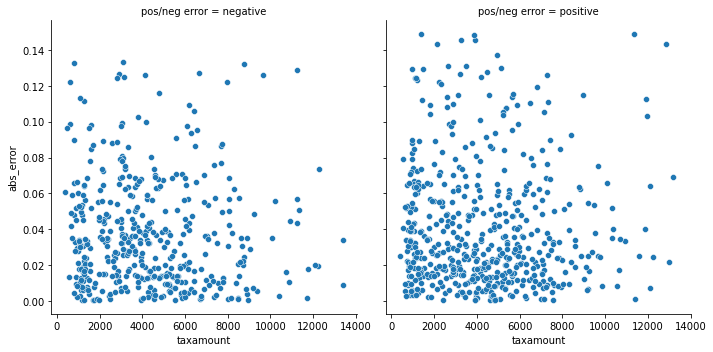

<Figure size 1008x432 with 0 Axes>

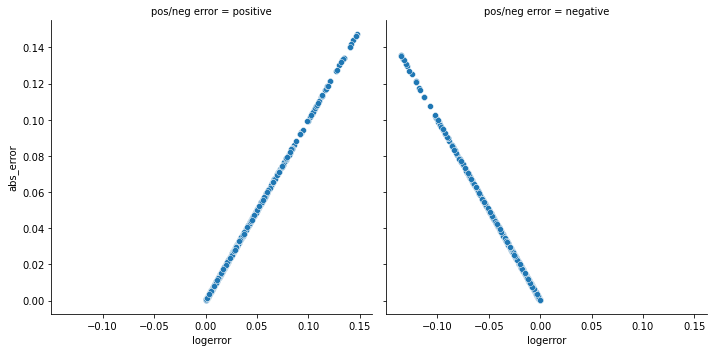

<Figure size 1008x432 with 0 Axes>

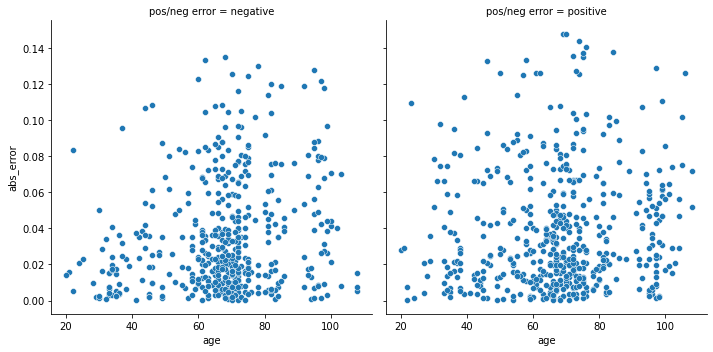

<Figure size 1008x432 with 0 Axes>

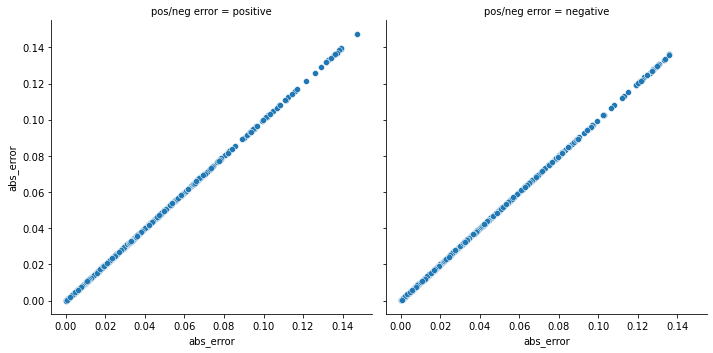

In [37]:
for col in num_cols:
    plt.figure(figsize=(14,6))
    sns.relplot(data=train.sample(n=1000), x=train[col], y='abs_error', col='pos/neg error')
    plt.show()

### Takeaways - Numeric Columns
* May want to create a new column that is the absolute value of the log error, and then another cat that says negative or positive error
* Need to check back and get rid of roomcnt, and a unitcnt 
* Greater errors
    - less bathrooms, moderate bedrooms

## Box Plot


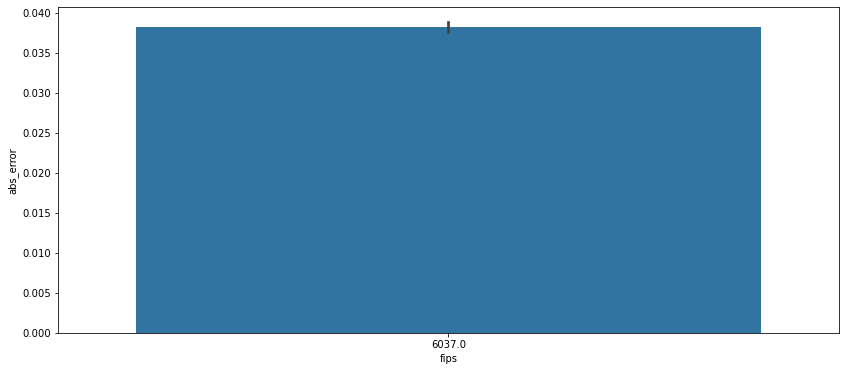

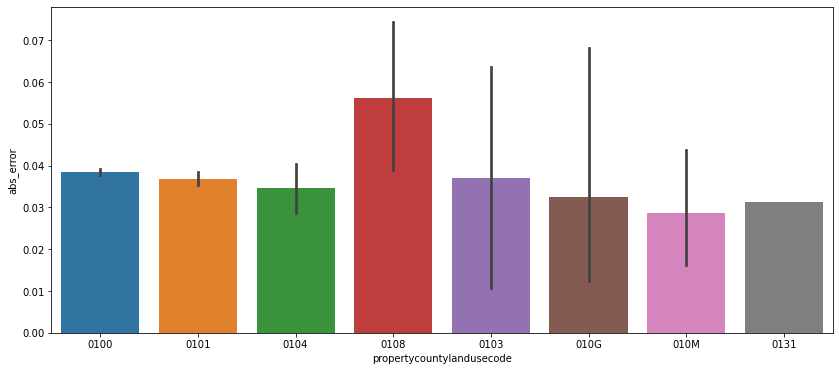

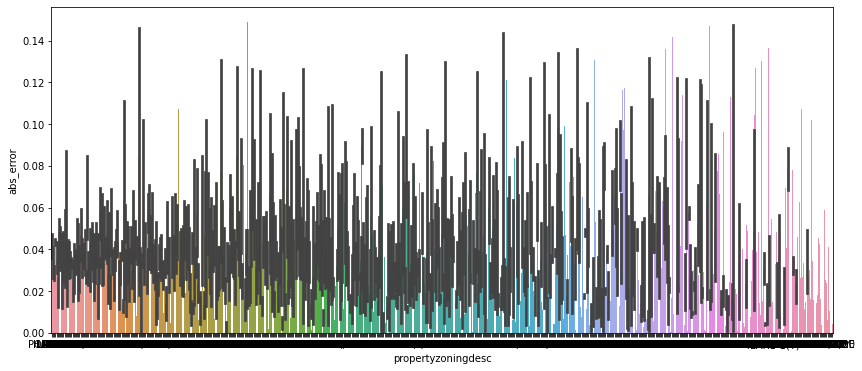

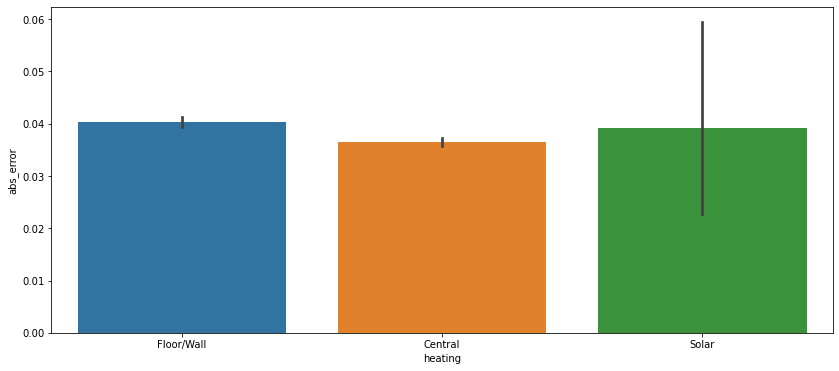

In [13]:
for col in cat_cols:
    plt.figure(figsize=(14,6))
    sns.barplot(data=train, x=train[col], y='abs_error')
    plt.show()

### Takeaways - Categorical
* Need to figure out what to do with census , regionidzip, regionidcity, propertyzoning desc
* higher absolute log errors in houses with floor/wall heating than other types

In [14]:
#code to try and put in cities by zip
# train.regionidzip.value_counts()
# train.regionidcity.value_counts()
# zip_codes = pd.read_csv('zip_codes.csv')
# zip_codes = zip_codes.rename(columns={'LOS ANGELES CITIES': 'City'})
# zip_codes = zip_codes.melt(id_vars=['City'])
# zip_codes = zip_codes.drop(columns='variable')
# zip_codes = zip_codes.dropna()
# pd.concat([train[['regionidzip']], zip_codes], join='outer')
# zip_codes = zip_codes.rename(columns={'value':'regionidzip'})
# train.regionidzip.value_counts()

In [33]:
train = train.drop(columns=['roomcnt', 'unitcnt'])

<AxesSubplot:>

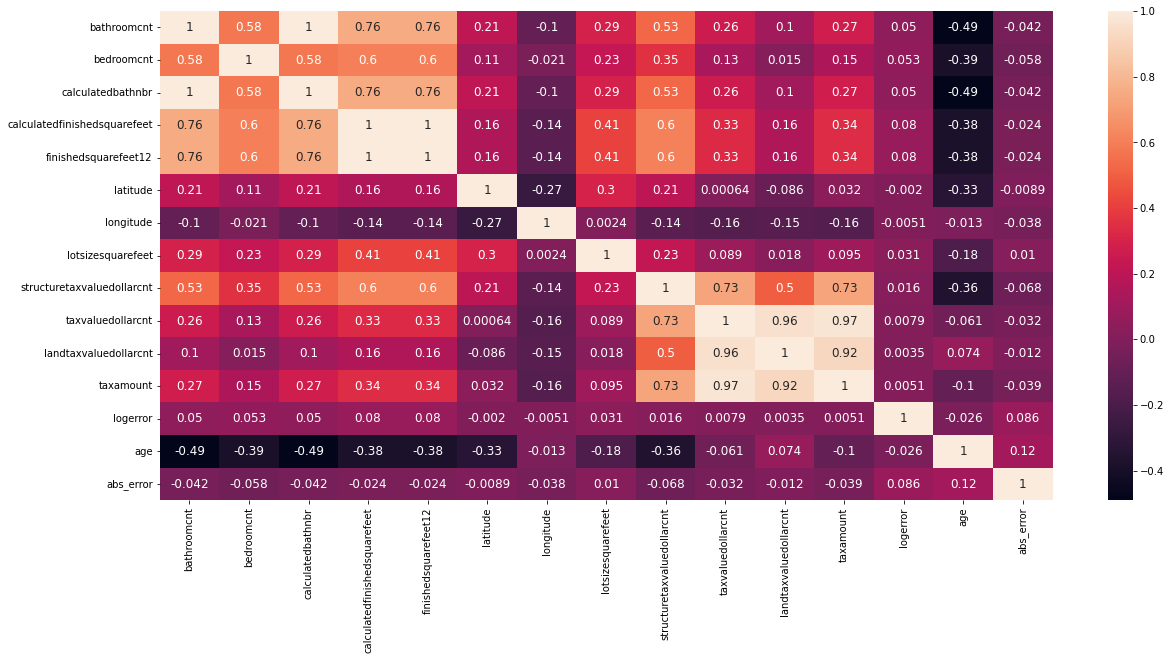

In [34]:
plt.figure(figsize=(20,9))
corr = train.corr()
sns.heatmap(corr, annot=True, annot_kws={"size":12})


#### Takeaways
* Basically useless
* the absolute error doesn't tell us much. ver minimal correlation with any category
    - investigate age, structuretaxvaluedollarcnt, bedroom cnt

## Q1 - Differences between mean absolute error between different ages

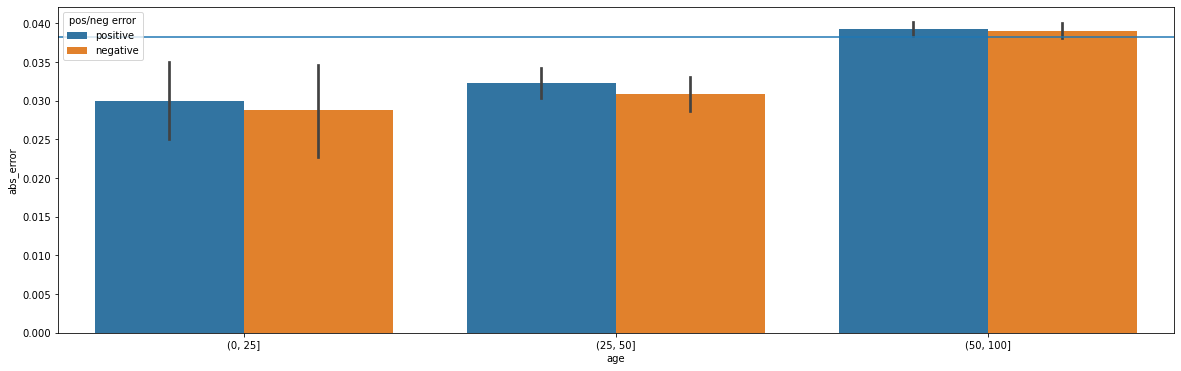

In [57]:
plt.figure(figsize=(20,6))
sns.barplot(data=train, x=pd.cut(train.age, [0, 25, 50, 100]), y='abs_error', hue='pos/neg error')
plt.axhline(y = train.abs_error.mean())

### Takeaway
* slight changes as homes get older. try using smaller bins
* range in error increates as homes age further than 50 years

## Q2 - Differences between mean absolute error and diffferent home sizes

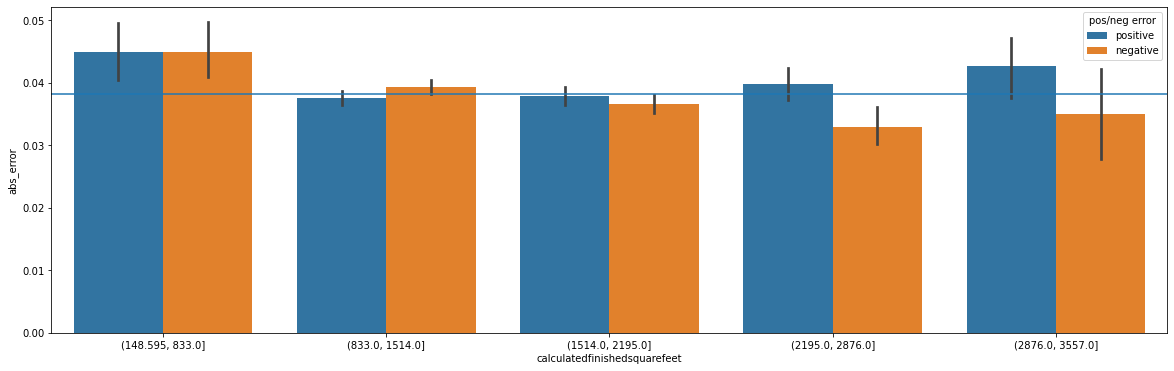

In [61]:
plt.figure(figsize=(20,6))
sns.barplot(data=train, 
    x=pd.cut(train.calculatedfinishedsquarefeet,5),
    y='abs_error', hue='pos/neg error')
plt.axhline(y = train.abs_error.mean())

## Q3 - Differences in mean absolute error between different numbers of bedrooms

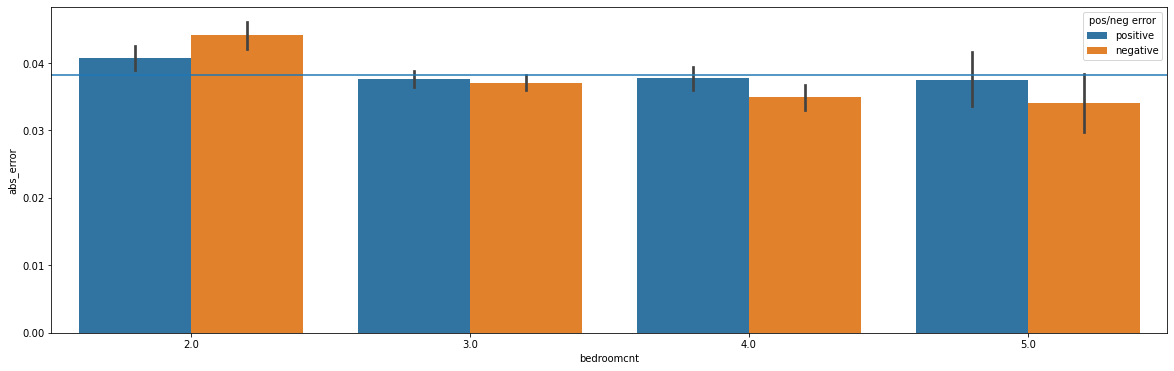

In [59]:
plt.figure(figsize=(20,6))
sns.barplot(data=train, x='bedroomcnt', y='abs_error', hue='pos/neg error')
plt.axhline(y = train.abs_error.mean())

## Q1 - Differences between mean absolute error and age

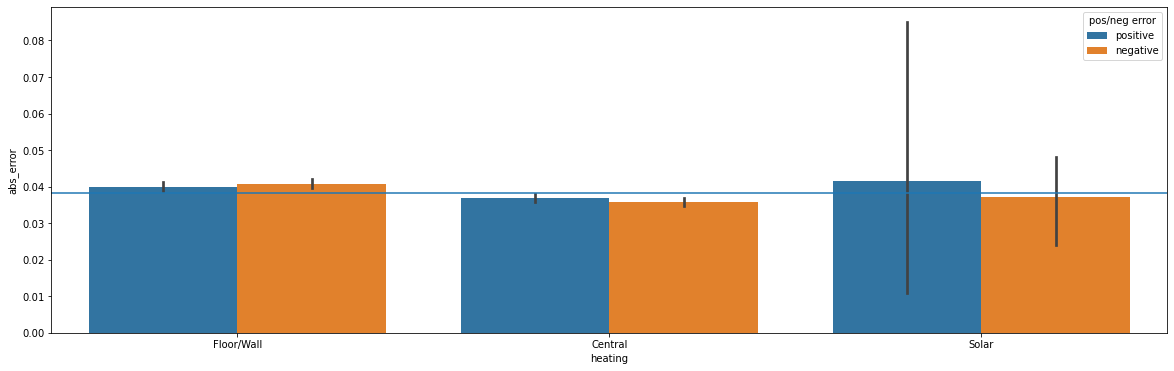

In [60]:
plt.figure(figsize=(20,6))
sns.barplot(data=train, x='heating', y='abs_error', hue='pos/neg error')
plt.axhline(y = train.abs_error.mean())

## Q1 - Differences between mean absolute error and age

Bonus:

Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.


